In [1]:
%pip install scikit-learn
%pip install matplotlib
%pip install pandas
%pip install tensorflow
%pip install numpy
%pip install ipympl
%pip install ipython
%pip install pyarrow
%pip install dask
%pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 51.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 110.1 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 94.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 98.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 56.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.7 MB/

In [24]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import multiprocessing as mp
import os
import time
import warnings
from datetime import datetime
from functools import partial
from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from tqdm import tqdm
import joblib

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

In [3]:
import logging
import sys

nblog = open("nb.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

In [9]:
# Training files
TRAIN_FILES = [
    "conn.log.labeled",
    "conn2.log.labeled",
    "conn3.log.labeled",
    #"conn4.log.labeled",
    "conn5.log.labeled",
]

columns = [
    "ts",
    "uid",
    "id.orig_h",
    "id.orig_p",
    "id.resp_h",
    "id.resp_p",
    "proto",
    "service",
    "duration",
    "orig_bytes",
    "resp_bytes",
    "conn_state",
    "local_orig",
    "local_resp",
    "missed_bytes",
    "history",
    "orig_pkts",
    "orig_ip_bytes",
    "resp_pkts",
    "resp_ip_bytes",
    "tunnel_parents",
    "label",
    "detailed-label",
]

In [ ]:
for file in TRAIN_FILES:
    with open(file, "r") as f:
        lines = f.readlines()

        with open(f"{file}.csv", "w") as ff:
            for line in lines[8:-1]:
                line = line.replace("\t", ",").replace("   ", ",")
                ff.write(line)

In [10]:
# data_train = pd.concat([pd.read_csv(f'{file}.csv', names=columns) for file in TRAIN_FILES], ignore_index=True)


def load_csv_parallel(file, columns):
    """Optimized CSV loading function for large files"""
    chunks = pd.read_csv(
        f"{file}.csv",
        names=columns,
        engine="c",
        low_memory=False,
        memory_map=True,
        cache_dates=True,
        chunksize=1_000_000,  # Process 1M rows at a time
    )
    return pd.concat(chunks, ignore_index=True, copy=False)


# Optimize for 64 cores, leaving 2 cores free for system processes
num_cores = 62

# Create process pool
with mp.Pool(num_cores) as pool:
    # Map the loading function across files
    dataframes = pool.starmap(
        load_csv_parallel, [(file, columns) for file in TRAIN_FILES]
    )

# Combine all files' dataframes
data_train = pd.concat(dataframes, ignore_index=True, copy=False)

# Clear unneeded variables to free memory
del dataframes

In [5]:
data_train.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.545337e+09,CddD2d1qU4UCgtFGV1,192.168.1.197,123,217.30.75.147,123,udp,-,0.002241,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-
1,1.545337e+09,CWsvajFlOE7fg2py4,192.168.1.197,123,94.124.107.190,123,udp,-,0.006726,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-
2,1.545337e+09,Cthriq2tzQhGjBK304,192.168.1.197,123,89.221.214.130,123,udp,-,0.003734,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-
3,1.545337e+09,CC2GtA46zw7L9veEI4,192.168.1.197,123,81.2.254.224,123,udp,-,0.004739,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-
4,1.545337e+09,CozNZa1gT9JUxCsqz2,192.168.1.197,123,81.2.248.189,123,udp,-,0.004739,48,48,SF,-,-,0,Dd,1,76,1,76,-,Benign,-


In [ ]:
data_train.describe().style.background_gradient(cmap="Blues").set_properties(
    **{"font-family": "Segoe UI"}
)

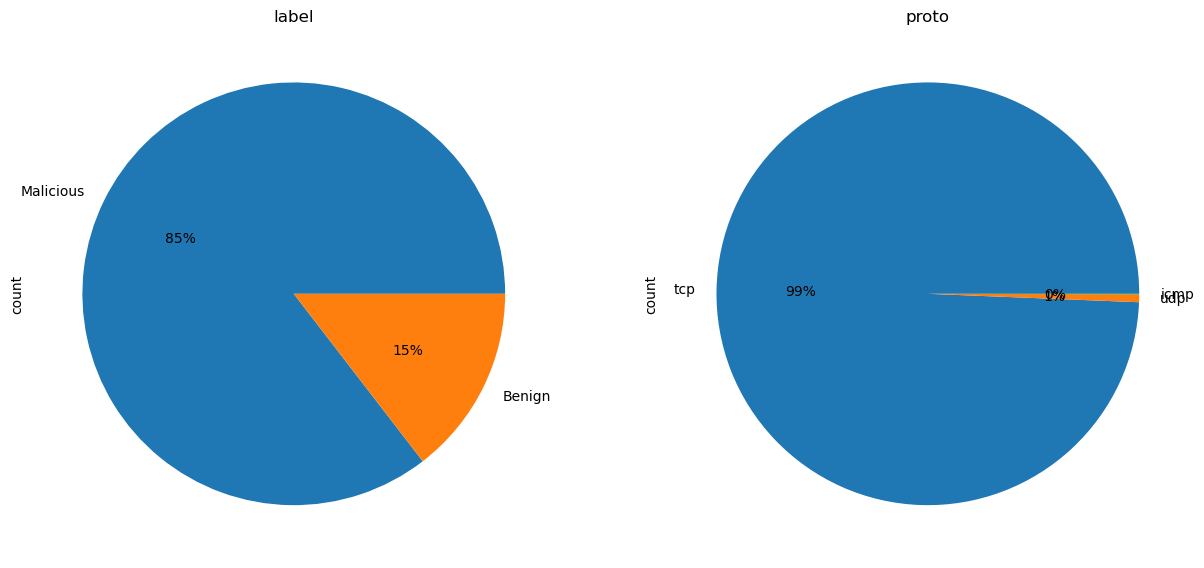

In [11]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(
            ax=ax, kind="pie", figsize=(15, 15), fontsize=10, autopct="%1.0f%%"
        )
        ax.set_title(str(col), fontsize=12)
    plt.show()


pie_plot(data_train, ["label", "proto"], 1, 2)

In [12]:
def Scaling(df_num, cols):
    """Optimized scaling function with progress tracking"""
    print(f"Starting RobustScaler on {len(cols)} columns...")
    t0 = time.time()
    
    # Initialize and fit scaler
    scaler = RobustScaler(copy=True)
    scaled_values = scaler.fit_transform(df_num)
    
    # Convert to DataFrame
    scaled_df = pd.DataFrame(scaled_values, columns=cols, index=df_num.index)
    
    print(f"Scaling completed in {time.time() - t0:.2f}s")
    return scaled_df

def preprocess(dataframe):
    """Optimized preprocessing pipeline with detailed progress tracking"""
    print("\n    Starting preprocessing pipeline...")
    print(f"    Initial dataframe shape: {dataframe.shape}")
    t_start = time.time()
    
    # Define columns to process
    cat_cols = ["proto", "service", "conn_state", "history"]
    drop_cols = [
       "ts", "uid", "id.orig_h", "id.resp_h", "id.orig_p", 
       "id.resp_p", "tunnel_parents", "detailed-label"
    ]
    
    # 1. Drop unnecessary columns
    print("\n    [1/7] Dropping unnecessary columns...")
    t0 = time.time()
    dataframe = dataframe.drop(columns=drop_cols, errors="ignore")
    print(f"    Columns dropped in {time.time() - t0:.2f}s")
    print(f"    Shape after dropping: {dataframe.shape}")
    
    # 2. Replace dashes with NaN
    print("\n    [2/7] Replacing dashes with NaN...")
    t0 = time.time()
    dataframe.replace("-", np.nan, inplace=True)
    print(f"    Replacement completed in {time.time() - t0:.2f}s")
    
    # 3. Process numeric columns
    print("\n    [3/7] Processing numeric columns...")
    t0 = time.time()
    numeric_cols = dataframe.columns.difference(cat_cols + ["label"])
    print(f"    Found {len(numeric_cols)} numeric columns")
    
    # Convert to numeric in chunks for better memory usage
    chunk_size = 5
    for i in range(0, len(numeric_cols), chunk_size):
       chunk_cols = numeric_cols[i:i+chunk_size]
       for col in chunk_cols:
           dataframe[col] = pd.to_numeric(dataframe[col], errors="coerce")
           
    print(f"    Numeric conversion completed in {time.time() - t0:.2f}s")
    
    # 4. Handle numeric data
    print("\n    [4/7] Processing numeric data and handling NaN values...")
    t0 = time.time()
    df_num = dataframe[numeric_cols]
    
    # Check for all-NaN columns
    all_nan_cols = df_num.columns[df_num.isna().all()]
    if len(all_nan_cols) > 0:
       print(f"    Found {len(all_nan_cols)} columns with all NaN values")
       df_num[all_nan_cols] = 0
    
    # Impute missing values
    print("Imputing missing values...")
    imputer = SimpleImputer(strategy="mean", copy=False)
    imputed_values = imputer.fit_transform(df_num)
    df_num = pd.DataFrame(imputed_values, columns=numeric_cols, index=dataframe.index)
    print(f"    Numeric processing completed in {time.time() - t0:.2f}s")
    
    # 5. Scale numeric data
    print("\n    [5/7] Scaling numeric data...")
    scaled_df = Scaling(df_num, df_num.columns)
    dataframe[df_num.columns] = scaled_df.values
    del scaled_df  # Free memory
    
    # 6. Convert labels
    print("\n    [6/7] Converting labels...")
    t0 = time.time()
    dataframe["label"] = (dataframe["label"] != "Benign").astype(np.int8)  # More efficient than lambda
    print(f"    Label conversion completed in {time.time() - t0:.2f}s")
    
    # 7. One-hot encode categorical columns
    print("\n    [7/7] One-hot encoding categorical columns...")
    t0 = time.time()
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True, sparse=False)
    print(f"    One-hot encoding completed in {time.time() - t0:.2f}s")
    
    # Final statistics
    print(f"\n    Final dataframe shape: {dataframe.shape}")
    print(f"    Memory usage: {dataframe.memory_usage().sum() / 1024**2:.2f} MB")
    print(f"    Total preprocessing time: {time.time() - t_start:.2f}s")
    
    return dataframe

In [13]:
print(f"[1/7] Starting preprocessing pipeline...")
print(f"Input shape: {data_train.shape}")
t0 = time.time()

# Preprocess data with progress tracking
print("[2/7] Preprocessing data...")
scaled_train = preprocess(data_train)
print(f"Preprocessing completed in {time.time() - t0:.2f}s")
print(f"Preprocessed shape: {scaled_train.shape}")

# Convert to float32 and split features/target
print("[3/7] Converting features to float32...")
t1 = time.time()
x = scaled_train.drop(["label"], axis=1, errors="ignore").values
x = np.asarray(x, dtype=np.float32)  # More efficient than .astype()
print(f"Features conversion completed in {time.time() - t1:.2f}s")
print(f"Features shape: {x.shape}")

print("[4/7] Converting labels to int32...")
t2 = time.time()
y = np.asarray(scaled_train["label"].values, dtype=np.int32)  # int32 is usually sufficient
print(f"Labels conversion completed in {time.time() - t2:.2f}s")
print(f"Labels shape: {y.shape}")

# Free memory
print("[5/7] Clearing unused data to free memory...")
del scaled_train
del data_train

# PCA with progress info
print("[6/7] Performing PCA reduction to 20 components...")
t3 = time.time()
pca = PCA(n_components=20, random_state=42)
x_reduced = pca.fit_transform(x)
print(f"PCA completed in {time.time() - t3:.2f}s")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
print(f"Reduced features shape: {x_reduced.shape}")

# Free more memory
del x

# Train test split
print("[7/7] Performing train-test split...")
t4 = time.time()
x_train, x_test, y_train, y_test = train_test_split(
   x_reduced, 
   y, 
   test_size=0.2, 
   random_state=42,
   shuffle=True,  # Explicit shuffle
   stratify=y     # Maintain label distribution
)
print(f"Split completed in {time.time() - t4:.2f}s")

# Print final shapes
print("\nFinal shapes:")
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print(f"\nTotal pipeline time: {time.time() - t0:.2f}s")

# Memory cleanup
del x_reduced

# Save PCA model
print("\nSaving PCA model...")
joblib.dump(pca, "pca_model.joblib")

[1/7] Starting preprocessing pipeline...
Input shape: (69492154, 23)
[2/7] Preprocessing data...

    Starting preprocessing pipeline...
    Initial dataframe shape: (69492154, 23)

    [1/7] Dropping unnecessary columns...
    Columns dropped in 6.34s
    Shape after dropping: (69492154, 15)

    [2/7] Replacing dashes with NaN...
    Replacement completed in 50.49s

    [3/7] Processing numeric columns...
    Found 10 numeric columns
    Numeric conversion completed in 22.65s

    [4/7] Processing numeric data and handling NaN values...
    Found 2 columns with all NaN values
Imputing missing values...
    Numeric processing completed in 35.93s

    [5/7] Scaling numeric data...
Starting RobustScaler on 10 columns...
Scaling completed in 15.94s

    [6/7] Converting labels...
    Label conversion completed in 3.92s

    [7/7] One-hot encoding categorical columns...
    One-hot encoding completed in 65.36s

    Final dataframe shape: (69492154, 246)
    Memory usage: 20942.23 MB
    T

['pca_model.joblib']

In [ ]:
# Save PCA model
print("\nSaving PCA model...")
joblib.dump(pca, "pca_model.joblib")

In [ ]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")


def create_packet_classifier(input_shape, num_classes=1):
    """
    Creates an optimized deep learning model for network packet classification
    with improved architecture and regularization.

    Args:
        input_shape: Shape of input features
        num_classes: Number of output classes (default 1 for binary classification)
    """

    # Initialize regularization parameters
    reg_config = {
        "kernel": regularizers.L1L2(l1=1e-6, l2=1e-5),
        "bias": regularizers.L2(1e-5),
        "activity": regularizers.L2(1e-6),
    }

    model = tf.keras.Sequential(
        [
            # Input layer with batch normalization
            layers.InputLayer(input_shape=input_shape),
            layers.BatchNormalization(),
            # First block - smaller layers for feature extraction
            layers.Dense(
                32,
                activation="relu",
                kernel_regularizer=reg_config["kernel"],
                bias_regularizer=reg_config["bias"],
                activity_regularizer=reg_config["activity"],
            ),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            # Second block - moderate size for pattern recognition
            layers.Dense(
                64,
                activation="relu",
                kernel_regularizer=reg_config["kernel"],
                bias_regularizer=reg_config["bias"],
                activity_regularizer=reg_config["activity"],
            ),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            # Third block - larger size for complex pattern learning
            layers.Dense(
                256,
                activation="relu",
                kernel_regularizer=reg_config["kernel"],
                bias_regularizer=reg_config["bias"],
                activity_regularizer=reg_config["activity"],
            ),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            # Output layer
            layers.Dense(num_classes, activation="sigmoid"),
        ]
    )

    return model


def train_model(model, x_train, y_train, x_val, y_val, batch_size=32, max_epochs=50):
    """
    Trains the model with optimized parameters and callbacks.
    """

    # Define callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
        ),
        # Reduce learning rate when training plateaus
        ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
        ),
        # Save best model with .keras extension
        ModelCheckpoint(
            "best_packet_classifier.keras",  # Changed from .h5 to .keras
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1,
        ),
        TensorBoard(log_dir=log_dir, histogram_freq=1),
    ]

    # Compile model with optimized parameters
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-3,
        clipnorm=1.0,  # Gradient clipping to prevent exploding gradients
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
        ],
    )

    # Train model
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=callbacks,
        verbose=1,
    )

    return history


# Example usage:
def preprocess_data(columns, data):
    """
    Preprocesses the network packet data.
    """
    # Convert categorical columns to numerical
    categorical_columns = [
        "proto",
        "service",
        "conn_state",
        "history",
        "tunnel_parents",
    ]
    numerical_columns = [
        col
        for col in columns
        if col not in categorical_columns + ["label", "detailed-label"]
    ]

    # Normalize numerical features
    scaler = StandardScaler()
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    # One-hot encode categorical features
    for col in categorical_columns:
        data = pd.get_dummies(data, columns=[col], prefix=col)

    return data

In [ ]:
input_shape = x_train.shape[1:]
print("Shaped")
model = create_packet_classifier(input_shape)
print("model")
history = train_model(model, x_train, y_train, x_test, y_test)

In [18]:
with open("test2.log.labeled", "r") as f:
    lines = f.readlines()

    with open("test2.log.labeled.csv", "w") as ff:
        for line in lines[8:-1]:
            line = line.replace("\t", ",").replace("   ", ",")
            ff.write(line)


    Starting preprocessing pipeline...
    Initial dataframe shape: (156102, 23)

    [1/7] Dropping unnecessary columns...
    Columns dropped in 0.01s
    Shape after dropping: (156102, 15)

    [2/7] Replacing dashes with NaN...
    Replacement completed in 0.11s

    [3/7] Processing numeric columns...
    Found 10 numeric columns
    Numeric conversion completed in 0.12s

    [4/7] Processing numeric data and handling NaN values...
    Found 2 columns with all NaN values
Imputing missing values...
    Numeric processing completed in 0.03s

    [5/7] Scaling numeric data...
Starting RobustScaler on 10 columns...
Scaling completed in 0.03s

    [6/7] Converting labels...
    Label conversion completed in 0.01s

    [7/7] One-hot encoding categorical columns...
    One-hot encoding completed in 0.06s

    Final dataframe shape: (156102, 92)
    Memory usage: 24.12 MB
    Total preprocessing time: 0.39s
Performing PCA reduction...
Explained variance ratio: 1.000
4879/4879 ━━━━━━━━━━━

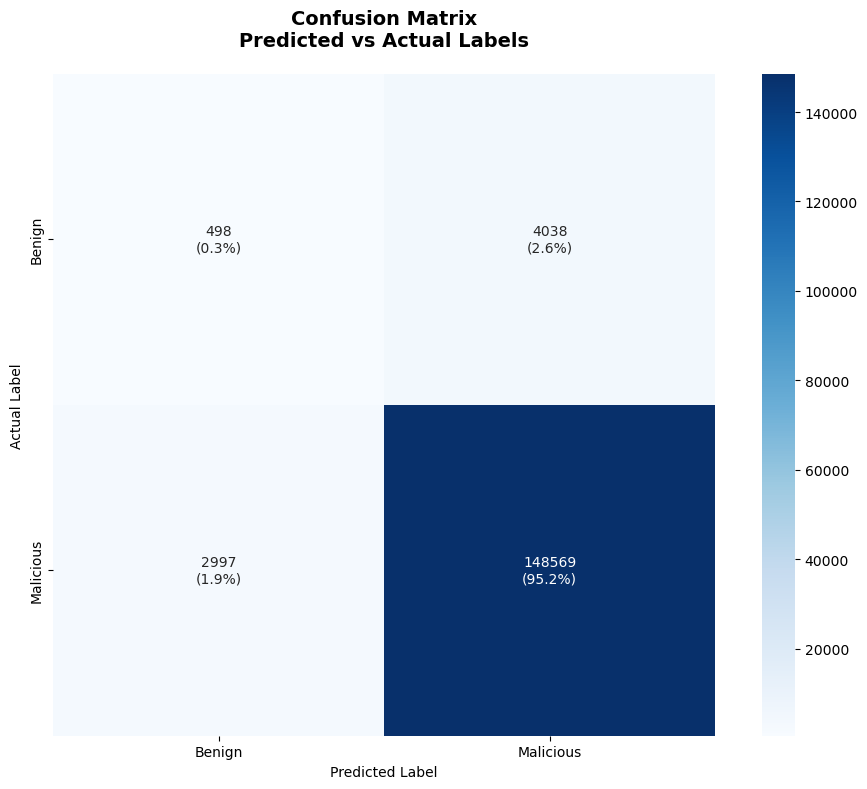

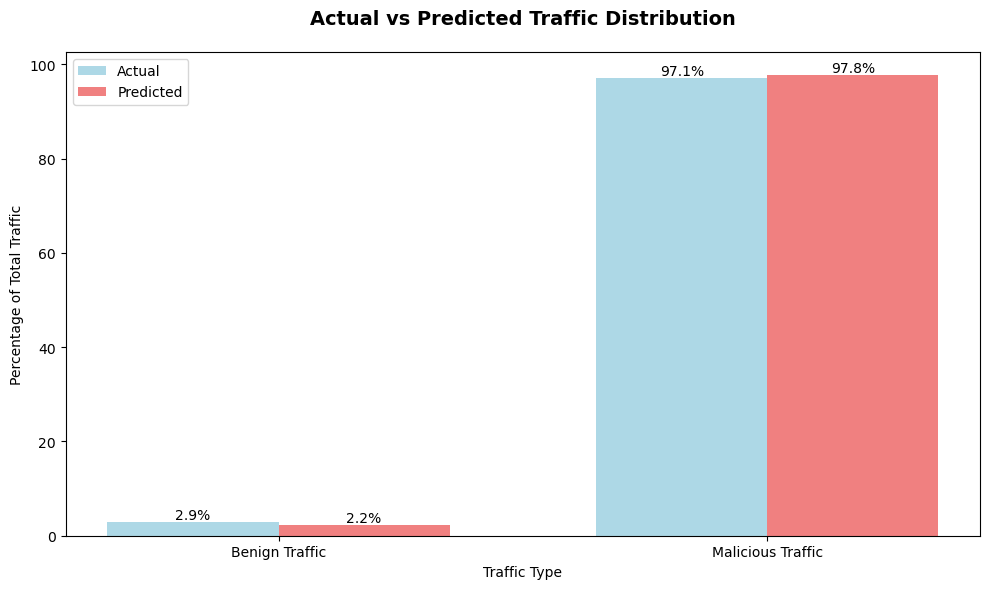

<Figure size 1200x600 with 0 Axes>

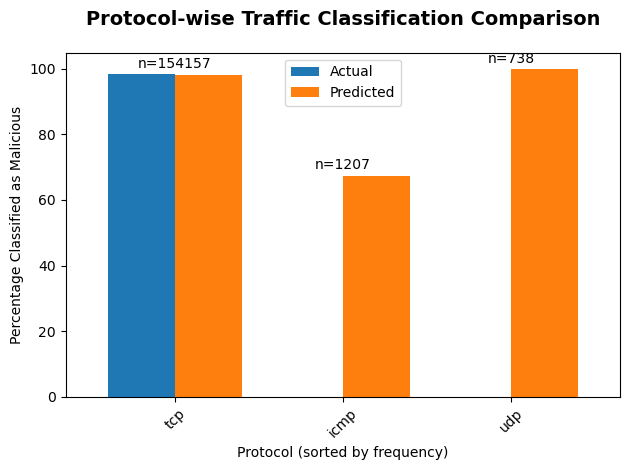


Model Performance Metrics:
--------------------------------------------------
Accuracy: 0.9549
Precision: 0.9735
Recall: 0.9802
F1 Score: 0.9769

Confusion Matrix Interpretation:
--------------------------------------------------
True Negatives (Correctly identified benign traffic): 498
False Positives (Benign traffic misclassified as malicious): 4038
False Negatives (Malicious traffic misclassified as benign): 2997
True Positives (Correctly identified malicious traffic): 148569

Protocol-wise Performance:
--------------------------------------------------
tcp        - Actual: 98.3% | Predicted: 98.0% | Count: 154157
icmp       - Actual: 0.0% | Predicted: 67.4% | Count: 1207
udp        - Actual: 0.0% | Predicted: 99.9% | Count: 738

Results saved to 'data' directory


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
import os
import time

# Load and preprocess data
df = pd.read_csv("test3.log.labeled.csv")

columns = [
    "ts", "uid", "id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p",
    "proto", "service", "duration", "orig_bytes", "resp_bytes",
    "conn_state", "local_orig", "local_resp", "missed_bytes",
    "history", "orig_pkts", "orig_ip_bytes", "resp_pkts",
    "resp_ip_bytes", "tunnel_parents", "label", "detailed-label"
]

df.columns = columns
required_columns = [
    "proto", "service", "conn_state", "history", "local_orig", "local_resp",
    "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "resp_pkts"
]

for col in required_columns:
    if col not in df.columns:
        df[col] = np.nan

# Store actual labels
actual_labels = df['label'].map({'Benign': 0, 'Malicious': 1}).fillna(0).astype(int)

# Preprocess the data
preprocessed_data = preprocess(df)

# Load model and make predictions
model = load_model("best_packet_classifier.keras")

# Perform PCA
print("Performing PCA reduction...")
pca = PCA(n_components=20, random_state=42)
x_new = preprocessed_data.values.astype("float32")
x_new_reduced = pca.fit_transform(x_new)
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")

# Get predictions
predictions_prob = model.predict(x_new_reduced)
predictions = (predictions_prob > 0.5).astype("int")

# Create figure for confusion matrix with better labels
plt.figure(figsize=(10, 8))
cm = confusion_matrix(actual_labels, predictions)

# Create labeled confusion matrix
labels = ['Benign', 'Malicious']
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Calculate percentages for annotations
cm_norm = cm.astype('float') / cm.sum()
annotations = np.array([f'{count}\n({percentage:.1%})'
                       for count, percentage in zip(cm.flatten(), cm_norm.flatten())])
annotations = annotations.reshape(cm.shape)

# Plot confusion matrix with better styling
sns.heatmap(cm_df, 
            annot=annotations,
            fmt='',
            cmap='Blues',
            square=True,
            cbar=True)

plt.title('Confusion Matrix\nPredicted vs Actual Labels', 
          pad=20, 
          fontsize=14, 
          fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()

# Create comparison bar chart
plt.figure(figsize=(10, 6))
comparison_data = pd.DataFrame({
    'Actual': actual_labels,
    'Predicted': predictions.flatten()
})

# Calculate percentages
actual_pct = (comparison_data['Actual'].value_counts() / len(actual_labels) * 100).round(2)
predicted_pct = (comparison_data['Predicted'].value_counts() / len(predictions) * 100).round(2)

x = np.arange(2)
width = 0.35

plt.bar(x - width/2, [actual_pct.get(0, 0), actual_pct.get(1, 0)], 
        width, label='Actual', color='lightblue')
plt.bar(x + width/2, [predicted_pct.get(0, 0), predicted_pct.get(1, 0)], 
        width, label='Predicted', color='lightcoral')

plt.xlabel('Traffic Type')
plt.ylabel('Percentage of Total Traffic')
plt.title('Actual vs Predicted Traffic Distribution', pad=20, fontsize=14, fontweight='bold')
plt.xticks(x, ['Benign Traffic', 'Malicious Traffic'])
plt.legend()

# Add percentage labels on bars
for i, v in enumerate([actual_pct.get(0, 0), actual_pct.get(1, 0)]):
    plt.text(i - width/2, v, f'{v:.1f}%', ha='center', va='bottom')
for i, v in enumerate([predicted_pct.get(0, 0), predicted_pct.get(1, 0)]):
    plt.text(i + width/2, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Protocol-wise comparison
plt.figure(figsize=(12, 6))
protocol_comparison = pd.DataFrame({
    'Protocol': df['proto'],
    'Actual': actual_labels,
    'Predicted': predictions.flatten()
})

protocol_stats = protocol_comparison.groupby('Protocol').agg({
    'Actual': ['mean', 'count'],
    'Predicted': 'mean'
})

protocol_stats.columns = ['Actual_Rate', 'Count', 'Predicted_Rate']
protocol_stats = protocol_stats.sort_values('Count', ascending=False)

# Convert to percentages
protocol_stats['Actual_Rate'] *= 100
protocol_stats['Predicted_Rate'] *= 100

ax = protocol_stats[['Actual_Rate', 'Predicted_Rate']].plot(
    kind='bar',
    rot=45,
    width=0.8
)

plt.title('Protocol-wise Traffic Classification Comparison', 
          pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Protocol (sorted by frequency)')
plt.ylabel('Percentage Classified as Malicious')
plt.legend(['Actual', 'Predicted'])

# Add count annotations
for i, (idx, row) in enumerate(protocol_stats.iterrows()):
    plt.text(i, max(row['Actual_Rate'], row['Predicted_Rate']) + 1,
             f'n={int(row["Count"])}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate and display metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("\nModel Performance Metrics:")
print("-" * 50)
print(f"Accuracy: {accuracy_score(actual_labels, predictions):.4f}")
print(f"Precision: {precision_score(actual_labels, predictions):.4f}")
print(f"Recall: {recall_score(actual_labels, predictions):.4f}")
print(f"F1 Score: {f1_score(actual_labels, predictions):.4f}")

print("\nConfusion Matrix Interpretation:")
print("-" * 50)
print(f"True Negatives (Correctly identified benign traffic): {cm[0,0]}")
print(f"False Positives (Benign traffic misclassified as malicious): {cm[0,1]}")
print(f"False Negatives (Malicious traffic misclassified as benign): {cm[1,0]}")
print(f"True Positives (Correctly identified malicious traffic): {cm[1,1]}")

# Protocol-wise Performance
print("\nProtocol-wise Performance:")
print("-" * 50)
for protocol, stats in protocol_stats.iterrows():
    print(f"{protocol:10} - Actual: {stats['Actual_Rate']:.1f}% | "
          f"Predicted: {stats['Predicted_Rate']:.1f}% | "
          f"Count: {int(stats['Count'])}")

# Save results
os.makedirs("data", exist_ok=True)
df['actual_label'] = actual_labels
df['predicted_label'] = predictions
df.to_csv("data/comparison_results.csv", index=False)

# Save summary statistics
summary_stats = {
    "total_packets": len(df),
    "actual_malicious": int(actual_labels.sum()),
    "predicted_malicious": int(predictions.sum()),
    "confusion_matrix": {
        "true_negatives": int(cm[0,0]),
        "false_positives": int(cm[0,1]),
        "false_negatives": int(cm[1,0]),
        "true_positives": int(cm[1,1])
    },
    "metrics": {
        "accuracy": float(accuracy_score(actual_labels, predictions)),
        "precision": float(precision_score(actual_labels, predictions)),
        "recall": float(recall_score(actual_labels, predictions)),
        "f1_score": float(f1_score(actual_labels, predictions))
    },
    "protocol_wise_stats": protocol_stats.to_dict(),
    "analysis_timestamp": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open("data/comparison_metrics.json", "w") as f:
    json.dump(summary_stats, f, indent=4)

print("\nResults saved to 'data' directory")